# Importing Libraries , Loading the Dataset , Data Pre Processing Operations 

Data Pre Processing Operations Includes :

1. Target Variable Cleaning and Binarization

2. Date-Time Parsing and Time-Series Feature Extraction

3. Missing Value Treatment and Rare Category Handling

4. One-Hot Encoding of Categorical Features

5. Feature Scaling and Outlier Clipping

6. Class Balancing Using SMOTE

Explanation of the SMOTE :

SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to balance imbalanced datasets. It creates synthetic examples of the minority class by interpolating between existing minority samples, improving model performance by preventing bias toward the majority class.

Explantion Of the Code :
    
The below code performs comprehensive data preprocessing steps for accident severity prediction.It begins by cleaning the dataset, converting severity into a binary target, and extracting meaningful time-based features. 

Categorical variables are one-hot encoded, numerical features are standardized, and outliers are handled. Finally, SMOTE is applied to balance the class distribution.

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Step 1: Load the dataset
df = pd.read_csv("Road_Accidents_Data.csv")
print("Dataset loaded successfully.")
print(df.head())
print("Initial shape of the dataset:", df.shape)

# Step 2: Fix and convert target labels
df['Accident_Severity'] = df['Accident_Severity'].replace('Fetal', 'Fatal')
df = df[df['Accident_Severity'].isin(['Slight', 'Serious', 'Fatal'])]
df['Accident_Severity'] = df['Accident_Severity'].apply(lambda x: 1 if x in ['Serious', 'Fatal'] else 0)
print("Target class distribution after conversion:\n", df['Accident_Severity'].value_counts())

# Step 3: Drop unnecessary ID and location columns
df.drop(columns=['Accident_Index', 'Latitude', 'Longitude', 'Police_Force'], inplace=True)

# Step 4: Drop rows with missing date or time
df.dropna(subset=['Accident Date', 'Time'], inplace=True)

# Step 5: Create datetime object
df['DateTime'] = pd.to_datetime(df['Accident Date'] + ' ' + df['Time'], errors='coerce')
df.dropna(subset=['DateTime'], inplace=True)

# Step 6: Extract time-based features
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year
df['Quarter'] = df['DateTime'].dt.quarter
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['Is_Night'] = df['Hour'].apply(lambda x: 1 if x < 6 or x >= 21 else 0)

# Step 7: Drop original date and time columns
df.drop(columns=['Accident Date', 'Time', 'DateTime'], inplace=True)

# Step 8: Remove duplicate records
df.drop_duplicates(inplace=True)

# Step 9: Treat missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Step 10: Remove rare categories from object columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    rare = df[col].value_counts()[df[col].value_counts() < 50].index
    df[col] = df[col].apply(lambda x: 'Other' if x in rare else x)

# Step 11: One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Step 12: Clip outliers in key numeric columns (optional but useful)
clip_cols = ['Speed_limit', 'Number_of_Casualties', 'Number_of_Vehicles']
for col in clip_cols:
    df[col] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))

# Step 13: Standardize numerical features
scale_cols = ['Speed_limit', 'Number_of_Casualties', 'Number_of_Vehicles', 'Hour', 'Month', 'Year']
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# Step 14: Define features and target
X = df.drop('Accident_Severity', axis=1)
y = df['Accident_Severity']

# Step 15: Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# Step 16: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 17: Output final summary
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())
print("Shape of X after SMOTE:", X_resampled.shape)
print("Shape of y after SMOTE:", y_resampled.shape)

Dataset loaded successfully.
  Accident_Index Accident Date Day_of_Week          Junction_Control  \
0      BS0000001    01-01-2021    Thursday  Give way or uncontrolled   
1      BS0000002    05-01-2021      Monday  Give way or uncontrolled   
2      BS0000003    04-01-2021      Sunday  Give way or uncontrolled   
3      BS0000004    05-01-2021      Monday       Auto traffic signal   
4      BS0000005    06-01-2021     Tuesday       Auto traffic signal   

           Junction_Detail Accident_Severity   Latitude  \
0  T or staggered junction           Serious  51.512273   
1               Crossroads           Serious  51.514399   
2  T or staggered junction            Slight  51.486668   
3  T or staggered junction           Serious  51.507804   
4               Crossroads           Serious  51.482076   

        Light_Conditions Local_Authority_(District) Carriageway_Hazards  ...  \
0               Daylight     Kensington and Chelsea                 NaN  ...   
1               Dayligh

# Exploratory Data Analysis 

Explanation of the Code :

Below code performs exploratory data analysis (EDA) through 10 distinct visualizations to understand accident patterns.It begins by examining target distribution and accident-related features like number of vehicles, casualties, and speed limits. 

A correlation heatmap reveals inter-feature relationships.Time-based visualizations follow, highlighting trends across hour, day, month, and year. Severity comparisons for weekends versus weekdays are also included. 

These insights help understand when and how severe accidents occur, supporting model development and decision-making.

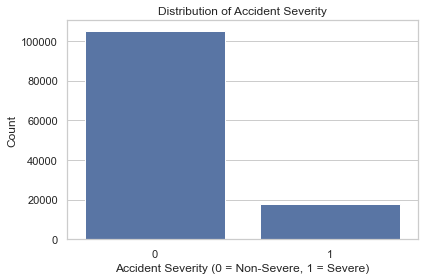

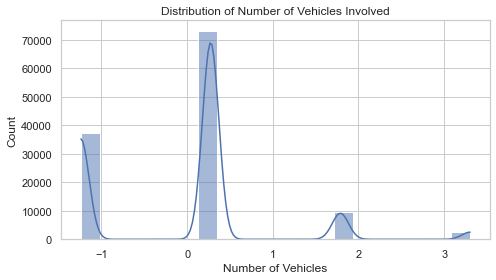

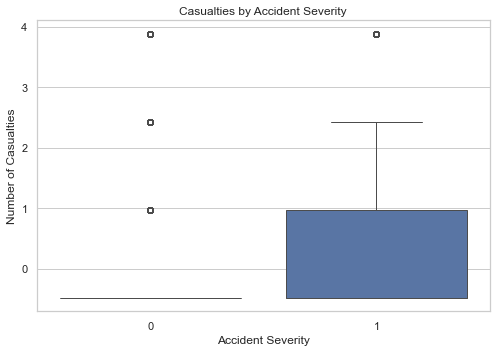

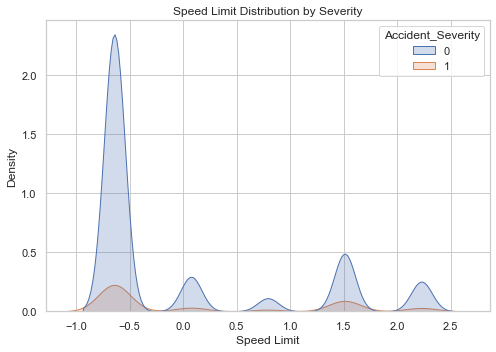

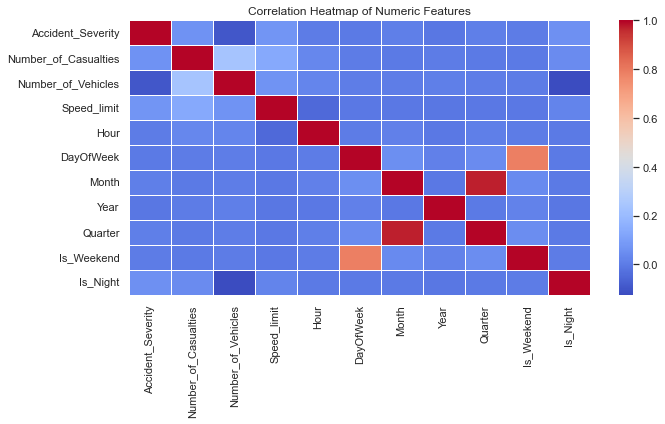

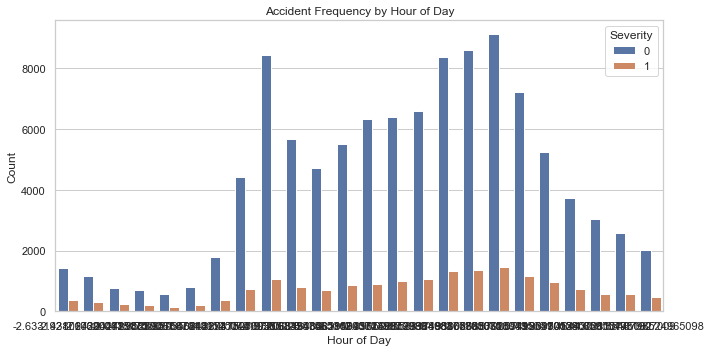

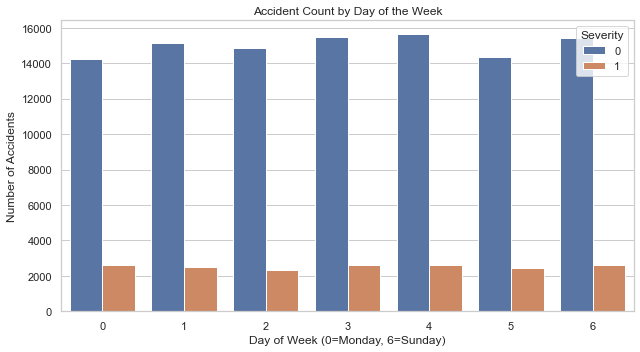

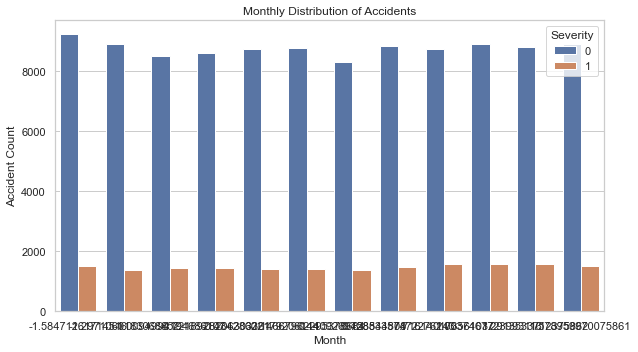

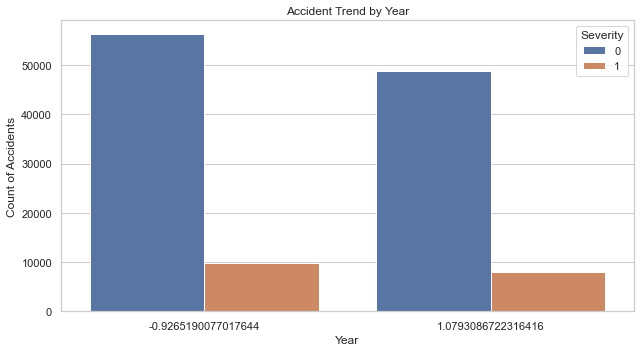

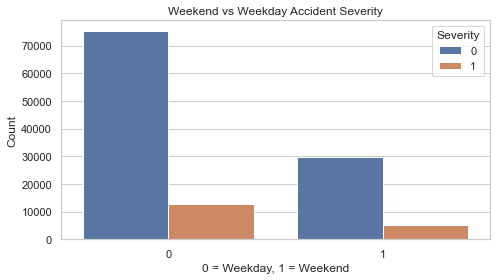

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")


# 1. Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Accident_Severity', data=df)
plt.title("Distribution of Accident Severity")
plt.xlabel("Accident Severity (0 = Non-Severe, 1 = Severe)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Distribution of number of vehicles
plt.figure(figsize=(7, 4))
sns.histplot(df['Number_of_Vehicles'], bins=20, kde=True)
plt.title("Distribution of Number of Vehicles Involved")
plt.xlabel("Number of Vehicles")
plt.tight_layout()
plt.show()

# 3. Boxplot of casualties by severity
plt.figure(figsize=(7, 5))
sns.boxplot(x='Accident_Severity', y='Number_of_Casualties', data=df)
plt.title("Casualties by Accident Severity")
plt.xlabel("Accident Severity")
plt.ylabel("Number of Casualties")
plt.tight_layout()
plt.show()

# 4. KDE plot of speed limits by severity
plt.figure(figsize=(7, 5))
sns.kdeplot(data=df, x='Speed_limit', hue='Accident_Severity', fill=True)
plt.title("Speed Limit Distribution by Severity")
plt.xlabel("Speed Limit")
plt.tight_layout()
plt.show()

# 5. Heatmap of correlations (numeric variables only)
plt.figure(figsize=(10, 6))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

# -------- TIME SERIES-INTEGRATED FIGURES -------- #

# 6. Accidents per hour (time series)
plt.figure(figsize=(10, 5))
sns.countplot(x='Hour', data=df, hue='Accident_Severity')
plt.title("Accident Frequency by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

# 7. Accidents by Day of Week
plt.figure(figsize=(9, 5))
sns.countplot(x='DayOfWeek', data=df, hue='Accident_Severity')
plt.title("Accident Count by Day of the Week")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

# 8. Accidents by Month
plt.figure(figsize=(9, 5))
sns.countplot(x='Month', data=df, hue='Accident_Severity')
plt.title("Monthly Distribution of Accidents")
plt.xlabel("Month")
plt.ylabel("Accident Count")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()

# 9. Yearly accident trend
plt.figure(figsize=(9, 5))
sns.countplot(x='Year', data=df, hue='Accident_Severity')
plt.title("Accident Trend by Year")
plt.xlabel("Year")
plt.ylabel("Count of Accidents")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

# 10. Weekend vs Weekday accidents
plt.figure(figsize=(7, 4))
sns.countplot(x='Is_Weekend', data=df, hue='Accident_Severity')
plt.title("Weekend vs Weekday Accident Severity")
plt.xlabel("0 = Weekday, 1 = Weekend")
plt.ylabel("Count")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()


# Target Variable Exploration and Visualization: Accident Severity 

Explanation of the Code :

Below Code introduces and explores the target variable for the project — Accident_Severity.It explains the binary classification format used in the model, identifies key supervised and unsupervised learning algorithms applied, and presents the major input features contributing to prediction.To support understanding of the class distribution and severity trends, three visualizations are provided:

A barchart comparing counts of severe vs. non-severe accidents.

A piechart showing their proportions.

A stacked barchart illustrating accident severity across days of the week.

Target Variable: Accident_Severity

The goal of this machine learning project is to assess the severity of road accidents.
The target feature, 'Accident_Severity', has been preprocessed into a binary format:
  - 0 indicates a non-severe accident (originally classified as 'Slight')
  - 1 indicates a severe accident (originally classified as 'Serious' or 'Fatal')

This binary label is used in supervised classification tasks.
The following algorithms are applied for prediction and comparison:
  1. Random Forest
  2. XGBoost
  3. Support Vector Machine (SVM)
  4. Logistic Regression

In addition to supervised learning, the project also includes an unsupervised learning algorithm:
  5. K-Means Clustering

K-Means is used to form clusters based solely on feature similarity, without using the target variable during training.
After clustering, the actual labels in 'Accident_Severity' can be used to evaluate how well the clusters correspond to real-world severity categories.

Key input features

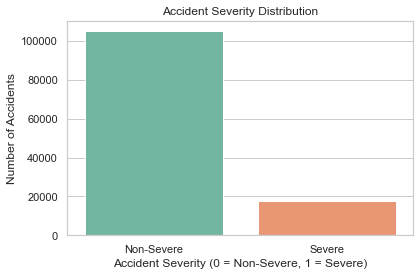

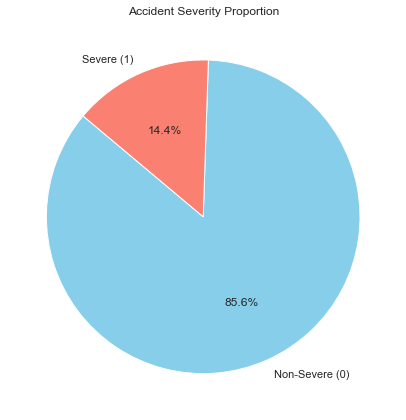

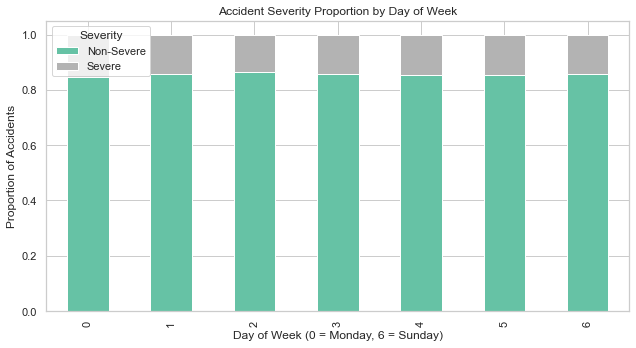

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Define the target variable for prediction and evaluation
target_column = 'Accident_Severity'

print("Target Variable:", target_column)
print()
print("The goal of this machine learning project is to assess the severity of road accidents.")
print("The target feature, 'Accident_Severity', has been preprocessed into a binary format:")
print("  - 0 indicates a non-severe accident (originally classified as 'Slight')")
print("  - 1 indicates a severe accident (originally classified as 'Serious' or 'Fatal')")
print()

print("This binary label is used in supervised classification tasks.")
print("The following algorithms are applied for prediction and comparison:")
print("  1. Random Forest")
print("  2. XGBoost")
print("  3. Support Vector Machine (SVM)")
print("  4. Logistic Regression")
print()

print("In addition to supervised learning, the project also includes an unsupervised learning algorithm:")
print("  5. K-Means Clustering")
print()
print("K-Means is used to form clusters based solely on feature similarity, without using the target variable during training.")
print("After clustering, the actual labels in 'Accident_Severity' can be used to evaluate how well the clusters correspond to real-world severity categories.")
print()

print("Key input features used in both supervised and unsupervised models include:")
print("  - Time-based features: Hour, DayOfWeek, Month, Year")
print("  - Road characteristics: Road Surface Conditions, Road Type, Speed Limit")
print("  - Environment-related features: Weather Conditions, Light Conditions, Urban or Rural Area")
print("  - Casualty and vehicle counts: Number of Vehicles, Number of Casualties")
print()

print("Current distribution of classes in the target variable:")
print(df[target_column].value_counts())


# Set Seaborn style
sns.set(style="whitegrid")

# Step 2: Bar Chart of target variable (Severity distribution)
plt.figure(figsize=(6, 4))
sns.countplot(x=target_column, hue=target_column, data=df, palette='Set2', legend=False)
plt.title("Accident Severity Distribution")
plt.xlabel("Accident Severity (0 = Non-Severe, 1 = Severe)")
plt.ylabel("Number of Accidents")
plt.xticks([0, 1], ['Non-Severe', 'Severe'])
plt.tight_layout()
plt.show()

# Step 3: Pie Chart for target variable
severity_counts = df[target_column].value_counts()
labels = ['Non-Severe (0)', 'Severe (1)']
colors = ['skyblue', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(severity_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Accident Severity Proportion")
plt.tight_layout()
plt.show()

# Step 4: Stacked Bar Chart - Severity distribution by DayOfWeek
severity_by_day = df.groupby(['DayOfWeek', 'Accident_Severity']).size().unstack(fill_value=0)
severity_by_day_percent = severity_by_day.divide(severity_by_day.sum(axis=1), axis=0)

severity_by_day_percent.plot(kind='bar', stacked=True, figsize=(9, 5), colormap='Set2')
plt.title("Accident Severity Proportion by Day of Week")
plt.xlabel("Day of Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Proportion of Accidents")
plt.legend(title="Severity", labels=['Non-Severe', 'Severe'])
plt.tight_layout()
plt.show()

# Feature Selection and Importance Analysis

Explanaton of the Code :

Below Code refines the feature set to improve model performance and reduce redundancy. The steps include:

Low Variance Filtering: Features with little to no variation are removed using VarianceThreshold.

Correlation Analysis: A heatmap highlights inter-feature correlations. Highly correlated features (correlation > 0.9) are dropped to prevent multicollinearity.

Feature Importance (Random Forest): A Random Forest classifier identifies the top 15 most important features based on their contribution to predicting accident severity.
Visualizations help interpret the remaining features and guide informed model development.

Remaining features after low-variance filtering: 10


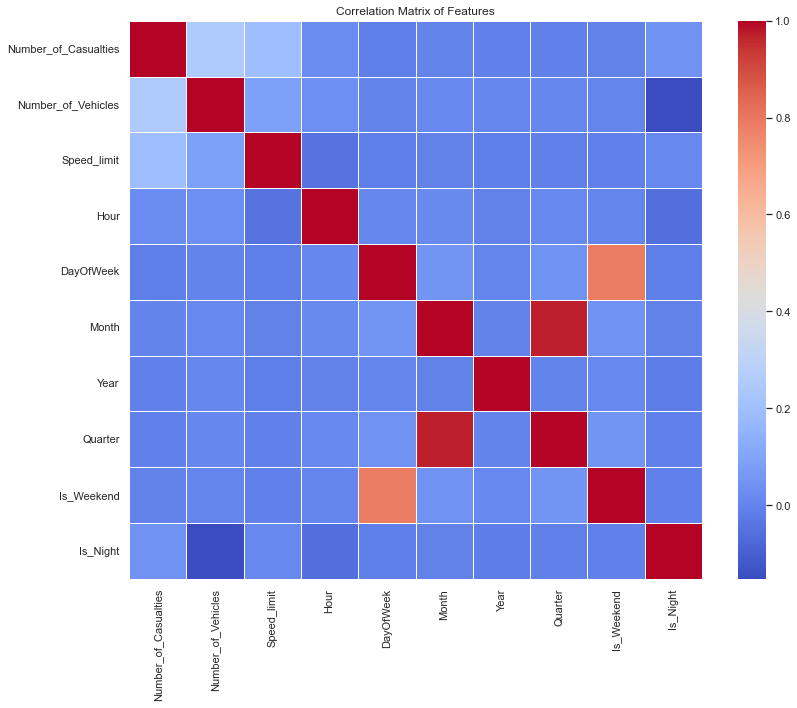

Dropped highly correlated features: ['Quarter']
Shape after dropping high-correlation features: (210266, 9)


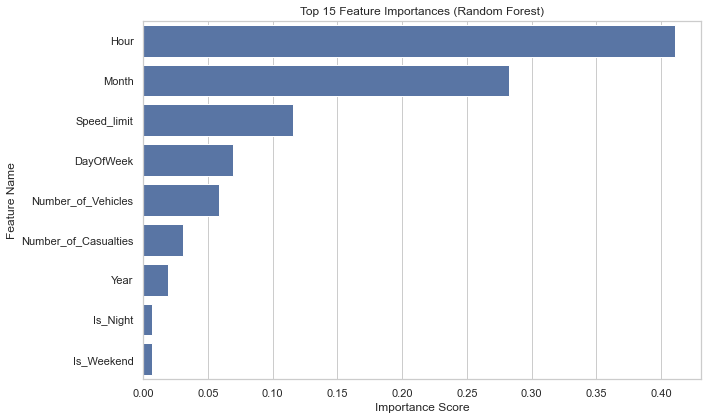

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

# Step 1: Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X_resampled)

# Get retained feature names
selected_columns = X_resampled.columns[selector.get_support()]
X_resampled = pd.DataFrame(X_var, columns=selected_columns)

print("Remaining features after low-variance filtering:", X_resampled.shape[1])

# Step 2: Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = X_resampled.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()

# Drop highly correlated features (|corr| > 0.9)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper_triangle.columns if any(upper_triangle[col].abs() > 0.9)]
X_resampled.drop(columns=high_corr_features, inplace=True)

print("Dropped highly correlated features:", high_corr_features)
print("Shape after dropping high-correlation features:", X_resampled.shape)

# Step 3: Feature importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

importances = rf_model.feature_importances_
feature_names = X_resampled.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot top 15 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

# Train-Test Split for Model Evaluation

Explanation of the Code :
    
Below Code divides the balanced dataset (after applying SMOTE) into training and testing subsets using an 80:20 split with stratification to preserve class distribution.
Key outputs include the shapes of training and testing sets, class distributions in each, and the total number of records involved.
This step is essential for ensuring fair and consistent model evaluation.

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

# Display the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Display class distribution in training set
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)

# Display class distribution in testing set
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

# Display total number of records
print("\nTotal records after SMOTE:", len(y_resampled))
print("Training records:", len(y_train))
print("Testing records:", len(y_test))

X_train shape: (168212, 9)
y_train shape: (168212,)
X_test shape: (42054, 9)
y_test shape: (42054,)

Class distribution in training set:
Accident_Severity
1    50.0
0    50.0
Name: proportion, dtype: float64

Class distribution in testing set:
Accident_Severity
1    50.0
0    50.0
Name: proportion, dtype: float64

Total records after SMOTE: 210266
Training records: 168212
Testing records: 42054


# Model Evaluation and Performance Analysis For Supervised Learning Algorithms 

# Model Evaluation and Performance Analysis of Logistic Regression, Decision Tree, Random Forest, and XGBoost Classifiers

Evaluated algorithms using the following metrics:

1. Classification Report
→ Includes Precision, Recall, F1-Score (harmonic mean of Precision and Recall), and Support (number of instances per class).

2. Accuracy
→ Overall proportion of correctly classified samples.

3. Confusion Matrix
→ Shows True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) to evaluate class-wise prediction errors.

4. ROC Curve (Receiver Operating Characteristic)
→ Plots True Positive Rate (Recall) vs. False Positive Rate at various threshold settings.
→ Also includes AUC (Area Under the Curve) to measure model separability.

# Model Evaluation: Random Forest Classifier Performance Analysis

Explanation of the Code:

Below code trains and evaluates a Random Forest Classifier for binary classification. 

It predicts labels, calculates evaluation metrics (accuracy), and prints a classification report. 

It also visualizes the confusion matrix and ROC curve to assess the model's performance on identifying accident severity (Severe vs Non-Severe).

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     21027
           1       0.87      0.81      0.84     21027

    accuracy                           0.84     42054
   macro avg       0.84      0.84      0.84     42054
weighted avg       0.84      0.84      0.84     42054

Accuracy: 0.8427


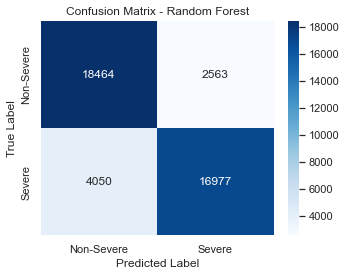

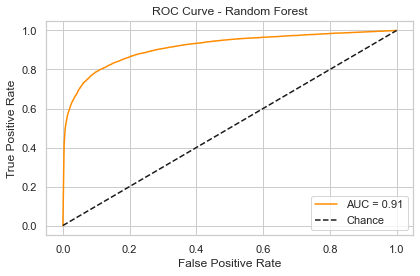

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. Train the Random Forest model =====
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# ===== 2. Make predictions =====
y_pred = rf_model.predict(X_test)                        # Predicted class labels
y_proba = rf_model.predict_proba(X_test)[:, 1]           # Predicted probabilities for ROC curve

# ===== 3. Evaluate performance =====
accuracy = accuracy_score(y_test, y_pred)                # Accuracy
mse = mean_squared_error(y_test, y_pred)                 # Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)                # Mean Absolute Error
rmse = np.sqrt(mse)                                      # Root Mean Squared Error

# ===== 4. Display classification report =====
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=2))

# ===== 5. Print metrics separately =====
print(f"Accuracy: {accuracy:.4f}")


# ===== 6. Confusion Matrix Visualization =====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== 7. ROC-AUC Curve =====
roc_auc = roc_auc_score(y_test, y_proba)                 # Compute AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)                 # False positive rate and true positive rate

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Model Evaluation: XGBoost Classifier Performance Analysis

Explanation of the Code :

Below code trains and evaluates a Random Forest Classifier for binary classification. 

It predicts labels, calculates evaluation metrics (accuracy), and prints a classification report. 

It also visualizes the confusion matrix and ROC curve to assess the model's performance on identifying accident severity (Severe vs Non-Severe).

=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       0.78      0.98      0.87     21027
           1       0.97      0.72      0.83     21027

    accuracy                           0.85     42054
   macro avg       0.88      0.85      0.85     42054
weighted avg       0.88      0.85      0.85     42054

Accuracy: 0.8504


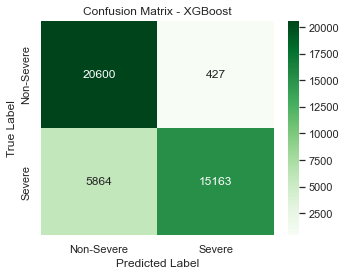

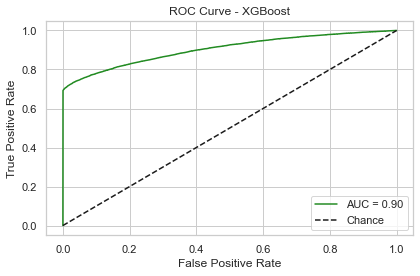

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. Train the XGBoost model =====
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')  # Removed deprecated use_label_encoder
xgb_model.fit(X_train, y_train)

# ===== 2. Make predictions =====
y_pred_xgb = xgb_model.predict(X_test)                        # Predicted class labels
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]           # Predicted probabilities for ROC curve

# ===== 3. Evaluate performance =====
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)             # Accuracy
mse_xgb = mean_squared_error(y_test, y_pred_xgb)              # Mean Squared Error
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)             # Mean Absolute Error
rmse_xgb = np.sqrt(mse_xgb)                                   # Root Mean Squared Error

# ===== 4. Display classification report =====
print("=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred_xgb, digits=2))

# ===== 5. Print metrics separately =====
print(f"Accuracy: {accuracy_xgb:.4f}")


# ===== 6. Confusion Matrix Visualization =====
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== 7. ROC-AUC Curve =====
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)              # Compute AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)          # FPR & TPR

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {roc_auc_xgb:.2f}", color='forestgreen')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Model Evaluation Logistic Regression  Performance Analysis

Explanation of the Code :

Below code trains and evaluates a Random Forest Classifier for binary classification. 

It predicts labels, calculates evaluation metrics (accuracy), and prints a classification report. 

It also visualizes the confusion matrix and ROC curve to assess the model's performance on identifying accident severity (Severe vs Non-Severe).

=== Classification Report (Logistic Regression) ===
              precision    recall  f1-score   support

           0       0.60      0.57      0.59     21027
           1       0.59      0.62      0.60     21027

    accuracy                           0.60     42054
   macro avg       0.60      0.60      0.60     42054
weighted avg       0.60      0.60      0.60     42054

Accuracy: 0.5954


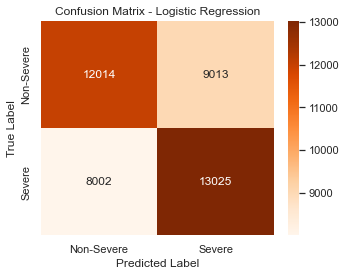

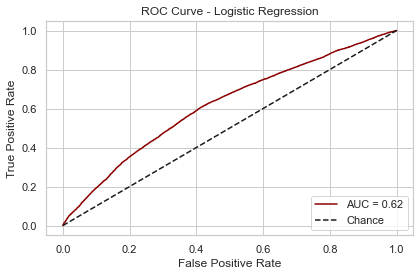

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. Train the Logistic Regression model =====
lr_model = LogisticRegression(random_state=42, max_iter=1000)   # Increase max_iter to avoid convergence warning
lr_model.fit(X_train, y_train)

# ===== 2. Make predictions =====
y_pred_lr = lr_model.predict(X_test)                            # Predicted class labels
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]               # Predicted probabilities for ROC curve

# ===== 3. Evaluate performance =====
accuracy_lr = accuracy_score(y_test, y_pred_lr)                 # Accuracy
mse_lr = mean_squared_error(y_test, y_pred_lr)                  # Mean Squared Error
mae_lr = mean_absolute_error(y_test, y_pred_lr)                 # Mean Absolute Error
rmse_lr = np.sqrt(mse_lr)                                       # Root Mean Squared Error

# ===== 4. Display classification report =====
print("=== Classification Report (Logistic Regression) ===")
print(classification_report(y_test, y_pred_lr, digits=2))

# ===== 5. Print metrics separately =====
print(f"Accuracy: {accuracy_lr:.4f}")


# ===== 6. Confusion Matrix Visualization =====
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== 7. ROC-AUC Curve =====
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)                  # Compute AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)              # FPR & TPR

plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f"AUC = {roc_auc_lr:.2f}", color='darkred')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Model Evaluation Decision Tree Classifier  Performance Analysis

Explanation of the Code :
    
Below code trains and evaluates a Random Forest Classifier for binary classification. 

It predicts labels, calculates evaluation metrics (accuracy), and prints a classification report.

It also visualizes the confusion matrix and ROC curve to assess the model's performance on identifying accident severity (Severe vs Non-Severe).

=== Classification Report (Decision Tree) ===
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     21027
           1       0.86      0.80      0.83     21027

    accuracy                           0.84     42054
   macro avg       0.84      0.84      0.84     42054
weighted avg       0.84      0.84      0.84     42054

Accuracy: 0.8364


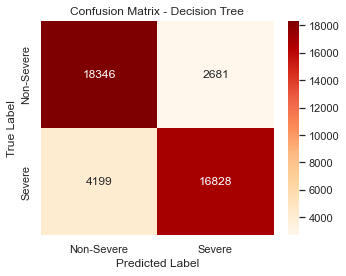

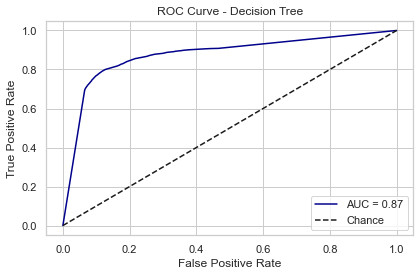

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===== 1. Train the Decision Tree model =====
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# ===== 2. Make predictions =====
y_pred_dt = dt_model.predict(X_test)                         # Predicted class labels
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]            # Predicted probabilities for ROC curve

# ===== 3. Evaluate performance =====
accuracy_dt = accuracy_score(y_test, y_pred_dt)              # Accuracy
mse_dt = mean_squared_error(y_test, y_pred_dt)               # Mean Squared Error
mae_dt = mean_absolute_error(y_test, y_pred_dt)              # Mean Absolute Error
rmse_dt = np.sqrt(mse_dt)                                    # Root Mean Squared Error

# ===== 4. Display classification report =====
print("=== Classification Report (Decision Tree) ===")
print(classification_report(y_test, y_pred_dt, digits=2))

# ===== 5. Print metrics separately =====
print(f"Accuracy: {accuracy_dt:.4f}")


# ===== 6. Confusion Matrix Visualization =====
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== 7. ROC-AUC Curve =====
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)               # Compute AUC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)            # FPR & TPR

plt.figure(figsize=(6, 4))
plt.plot(fpr_dt, tpr_dt, label=f"AUC = {roc_auc_dt:.2f}", color='darkblue')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Model Evaluation and Performance Analysis For Un Supervised Learning Algorithm 

# Model Evaluation and Performance Analysis For Hierarchical Clustering

Evaluated Clustering Algorithm (Hierarchical Clustering) using the following metrics:

1. Dendrogram Visualization
→ Used to understand the cluster formation and identify optimal cluster count.

2. Cluster Assignment & Distribution
→ Visualized cluster-wise distribution and sizes of assigned samples.

3. Average Feature Values per Cluster
→ Analyzed central tendencies to interpret characteristics of each cluster.

4. Silhouette Score
→ Measures how similar each point is to its own cluster vs. other clusters (range: -1 to 1).
→ Higher is better.

5. Calinski-Harabasz Index
→ Ratio of between-cluster dispersion to within-cluster dispersion.
→ Higher values indicate better-defined clusters.

Explanation of the Code :

Below code performs hierarchical clustering on a cleaned and standardized accident dataset. 

Categorical features are encoded, and a dendrogram visualizes cluster formation. 

It assigns data into three clusters, displays their distribution and average feature values, and evaluates clustering quality using Silhouette Score and Calinski-Harabasz Index for cohesion and separation analysis.

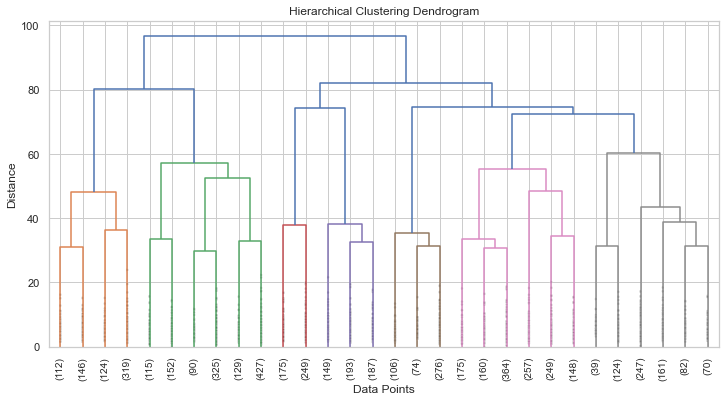

Cluster distribution:
 Cluster
3    2532
1    1939
2     953
Name: count, dtype: int64

Cluster-wise averages:
          Accident_Index  Accident Date  Day_of_Week  Junction_Control  \
Cluster                                                                 
1           2586.740588     369.789067     2.980918          3.491490   
2           2773.959077     380.463799     2.821616          3.508919   
3           2783.531991     359.214850     2.920616          3.526856   

         Junction_Detail  Accident_Severity   Latitude  Light_Conditions  \
Cluster                                                                    
1               4.598762           1.930892  52.769538          2.886024   
2               3.968520           1.889822  52.673002          3.459601   
3               3.435229           1.727488  52.396007          3.428515   

         Local_Authority_(District)  Carriageway_Hazards  ...  \
Cluster                                                   ...   
1          

In [17]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import warnings

# Suppress SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Load the dataset
df = pd.read_csv("Road_Accidents_Data.csv")

# Drop rows with missing values
df_clean = df.dropna().copy()

# Encode categorical features if present
for col in df_clean.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# Perform Hierarchical Clustering
linked = linkage(df_scaled, method='ward')

# Plot Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., 
           leaf_font_size=10., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Form flat clusters (e.g., 3 clusters)
clusters = fcluster(linked, 3, criterion='maxclust')

# Add cluster labels
df_clean.loc[:, 'Cluster'] = clusters

# Cluster distribution
print("Cluster distribution:\n", df_clean['Cluster'].value_counts())

# Analyze cluster characteristics
print("\nCluster-wise averages:\n", df_clean.groupby('Cluster').mean(numeric_only=True))

# Evaluation Metrics
silhouette_avg = silhouette_score(df_scaled, clusters)
calinski_harabasz = calinski_harabasz_score(df_scaled, clusters)

print("\n=== Evaluation Metrics ===")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

# Multiclass ROC Curve Analysis for Classification Models : Supervised Algorithms only

Explanation of the Code :

This code evaluates four classifiers (Random Forest, XGBoost, Logistic Regression, Decision Tree) on a multiclass classification task using One-vs-Rest strategy. 

It binarizes target labels, scales features, fits each model, and computes micro-averaged ROC curves. 

The ROC curves visualize how well each model distinguishes between classes across thresholds.

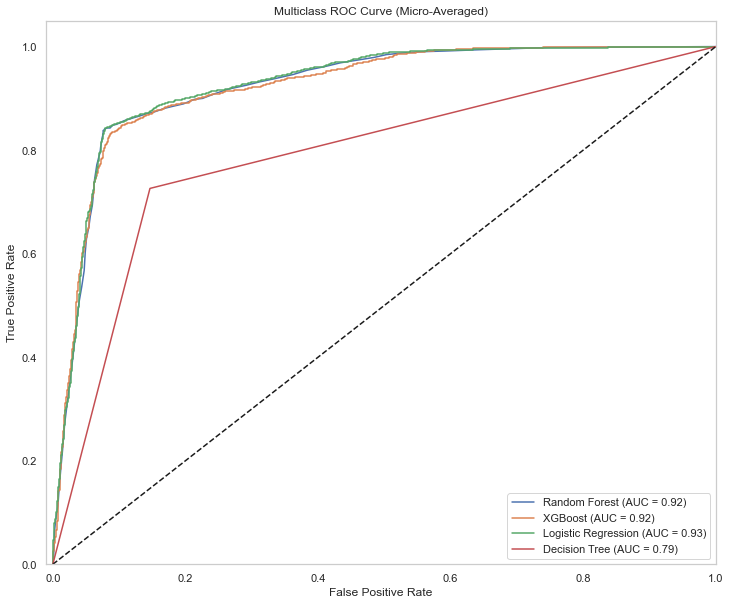

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize the target variable
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)
n_classes = y_bin.shape[1]

# Train-test split and scale
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.3, random_state=42, stratify=y_bin)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models
models = {
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(random_state=42)),
    "XGBoost": OneVsRestClassifier(XGBClassifier(eval_metric='mlogloss', random_state=42)),
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=10000, random_state=42)),
    "Decision Tree": OneVsRestClassifier(DecisionTreeClassifier(random_state=42)),
}

# Plot ROC curves
plt.figure(figsize=(12, 10))

for name, model in models.items():
    model.fit(X_train, y_train_bin)
    y_score = model.predict_proba(X_test)

    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"], label=f'{name} (AUC = {roc_auc["micro"]:.2f})')

# Final plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Micro-Averaged)')
plt.legend(loc="lower right")
plt.grid()
plt.show()
